# Predikcija ishoda biopsije na osnovu faktora rizika i rezultata rutinskih testova

U nastavku rada prikazana je procedura formiranja modela za predikciju rezultata biopsije u cilju dijagnoze raka grlića materice, korišćenjem različitih metoda mašinskog učenja.

In [34]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

sns.set(style="ticks", color_codes=True)
colors = sns.color_palette('pastel')[0:2]

Podaci koji se koriste za formiranje baze dostupni su za preuzimanje na linku https://www.kaggle.com/loveall/cervical-cancer-risk-classification, potiču sa Univerzitetske bolnice u Karakasu, Venecuela. Sadrže informacije o istoriji pacijentkinja neposredno pre izvršene biopsije zbog sumnje na dijagnozu raka grlića materice. Baza je veličine 858 primera. Prediktori su binarnog, celobrojnog i realnog tipa, i uključuju starost pacijentkinje, broj seksualnih partnera, uzrast prilikom prvog odnosa, broj trudnoća, zatim informaciju da li su pušači, koliko dugo i količinu cigareta na godišnjem nivou, informacije o hormonalnim kontraceptivima, IUD, kao i o različitim polno prenosivim bolestima i prethodnim dijagnozama. Posebnu pažnju treba obratiti na poslednja 3 prediktora: kolposkopija, razmaz rastvora joda i papa test. Ovi testovi rutinski se obavljaju prilikom preventivnih pregleda.

## Analiza prediktora

In [35]:
fileName = "kag_risk_factors_cervical_cancer.csv"
filePath = os.getcwd() + '/' + fileName
df = pd.read_csv(filePath)
print(df.keys())
linesToShow=3
print(df.iloc[np.r_[0:linesToShow, df.shape[0]-linesToShow:df.shape[0]],:])
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')
     Age Number of sexual partners First sexual intercourse  \
0     18                       4.0                     15.0   
1     15                       1.0             

Zbog brige oko privatnosti, pojedine pacijentkinje nisu se izjasnile o delovima svoje zdravstvene istorije. Stoga se javljaju nedostajuće vrednosti. Kolone u kojima fali veliki procenat vrednosti (kao što su STDs: Time since first diagnosis i STDs: Time since last diagnosis) odmah su izostavljene i nisu razmatrane u procesu formiranja modela. Posmatranjem standardnih devijacija prediktora uočeni su prediktori koji imaju istu vrednost za sve dostupne primere (STDs:AIDS, STDs:cervical condylomatosis), i oni su takođe izostavljene.

### Procenat nedostajućih vrednosti, srednje vrednosti i standardne devijacije

In [36]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
print(missing_value_df)
print("\n\nMean values:")
print(df.iloc[:,1:].mean(numeric_only=True))
print("\nStandard deviations:")
print(df.iloc[:,1:].std(numeric_only=True))

                                    percent_missing
Age                                        0.000000
Schiller                                   0.000000
Hinselmann                                 0.000000
Dx                                         0.000000
Dx:HPV                                     0.000000
Dx:CIN                                     0.000000
Dx:Cancer                                  0.000000
STDs: Number of diagnosis                  0.000000
Citology                                   0.000000
Biopsy                                     0.000000
First sexual intercourse                   0.815851
Smokes                                     1.515152
Smokes (years)                             1.515152
Smokes (packs/year)                        1.515152
Number of sexual partners                  3.030303
Num of pregnancies                         6.526807
STDs:HIV                                  12.237762
STDs:HPV                                  12.237762
STDs:Hepatit

### Raspodele pojedinačnih prediktora

Sledi eksplorativna analiza podataka. Najpre je uočena nebalansiranost klasa: 94% primera potiče iz klase pacijenata sa negativnim nalazom biopsije, odnosno 6% primera čine pacijenti kod kojih je biopsijom ustanovljen rak grlića materice. Dalje su pikazani histogrami i aproksimacije funkcije gustine raspodele 4 nebinarna prediktora. Zbog lakše vizualizacije na sledećoj figuri prikazana je funkcija raspodele ovih prediktora, ali odvojeno za različite ciljne klase. Prikazane su i statistike vezane za konzumiranje cigareta.

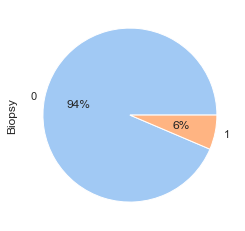

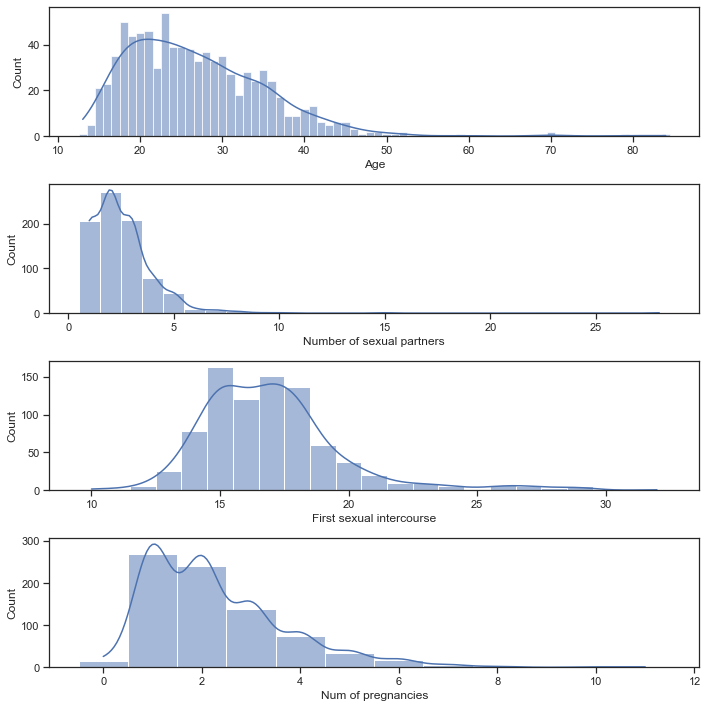

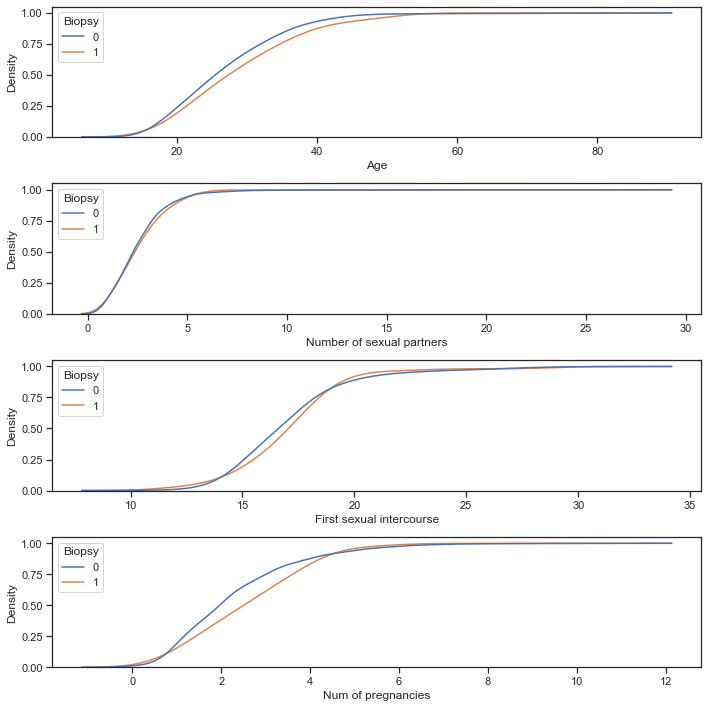

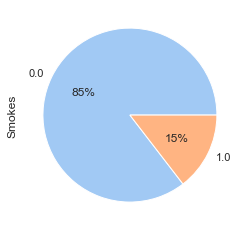

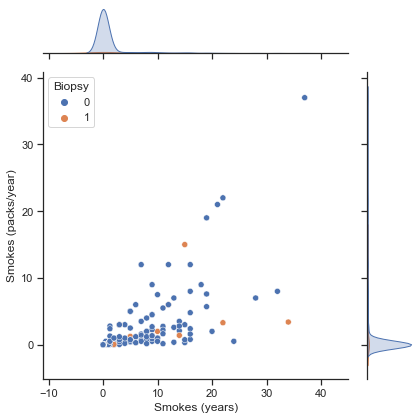

In [37]:
fig1, ax1 = plt.subplots()
df['Biopsy'].value_counts().plot(kind='pie',y='Biopsy',ax=ax1, colors=colors,autopct = '%0.0f%%')

fig2, axs21 = plt.subplots(4,1,figsize=(10,10))
sns.histplot(df,x="Age", ax=axs21[0], kde=True, discrete=True)
sns.histplot(df, x="Number of sexual partners", ax=axs21[1], kde = True, discrete=True)
sns.histplot(df, x="First sexual intercourse", ax=axs21[2], kde = True, discrete=True)
sns.histplot(df, x="Num of pregnancies", ax=axs21[3], kde = True, discrete=True)
plt.tight_layout()
fig22, axs22= plt.subplots(4,1,figsize=(10,10))
sns.kdeplot(
    data=df, x="Age", hue="Biopsy",
    cumulative=True, common_norm=False, common_grid=True, ax=axs22[0]
)
sns.kdeplot(
    data=df, x="Number of sexual partners", hue="Biopsy",
    cumulative=True, common_norm=False, common_grid=True, ax=axs22[1]
)
sns.kdeplot(
    data=df, x="First sexual intercourse", hue="Biopsy",
    cumulative=True, common_norm=False, common_grid=True, ax=axs22[2]
)
sns.kdeplot(
    data=df, x="Num of pregnancies", hue="Biopsy",
    cumulative=True, common_norm=False, common_grid=True, ax=axs22[3]
)
plt.tight_layout()
fig3, ax3 = plt.subplots()
df['Smokes'].value_counts().plot(kind='pie',y='Smokes',ax=ax3, colors=colors,autopct = '%0.0f%%')

sns.jointplot(data = df, x="Smokes (years)", y="Smokes (packs/year)",hue="Biopsy")
plt.tight_layout()


### Selekcija prediktora

Tri prediktora koja govore o pušačkim navikama ispitanica grupisani su u jedan zajednički prediktor koji je kontinualan i predstavlja količinu cigareta koju je ispitanica konzumirala. Analizom funkcije raspodele ovako formiranog prediktora može da se primeti da kod ispitanica sa pozitivnom biopsijom postoji veća gustina na vrednostima u opsegu 0-300 nego kod ispitanica koje imaju negativan nalaz biopsije.

0         0.0
1         0.0
2         0.0
3      1369.0
4         0.0
        ...  
853       0.0
854       0.0
855       0.0
856       0.0
857       0.0
Name: Smokes Combination, Length: 858, dtype: float64


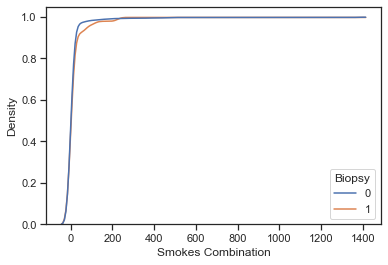

In [38]:
df["Smokes Combination"] = df["Smokes"] * df["Smokes (years)"] * df["Smokes (packs/year)"]
print(df["Smokes Combination"])
sns.kdeplot(
    data=df, x="Smokes Combination", hue="Biopsy",
    cumulative=True, common_norm=False, common_grid=True
)

Eliminisani su prediktori koji su grupisani u druge prediktore, koji imaju veliki broj nedostajućih vrednosti, koji imaju jednu konstantnu vrednost za sve ispitanice i za koje pored binarnog postoji i kontinualni prediktor.

In [39]:
df.drop(['Smokes','Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives','IUD','STDs', 'STDs:AIDS', 'STDs:cervical condylomatosis','STDs: Time since first diagnosis','STDs: Time since last diagnosis'], axis=1, inplace=True)

### Koeficijenti korelacije i povezanost prediktora

Međusobna povezanost prediktora i ciljne promenljive može se analizirati i koeficijentom korelacije. Evidentno je da tri testa koja se sprovode na pregledima kao deo prevencije daju najveće vrednosti korelacije sa rezultatom biopsije. Sledeće najkorelisanije promenljive su prethodna dijagnoza nekog tipa raka, dijagnoza infekcije HPV virusom, kao i postojanje prethodnih cervikalnih dijagnoza. Cela rang lista prikazana je u nastavku. Iz prikazanih konfuzionih matrica može se uvideti pouzdanost samih preventivnih testova, i da imaju manje-više značajan procenat propuštenih detekcija. Drugi prediktori koji govore o postojanju dijagnoza polno prenosivih bolesti korisni su jer mogu da se dovedu u vezu sa lažnim pozitivnim ili negativnim rezultatima preventivnih pregleda. 

['Age' 'Number of sexual partners' 'First sexual intercourse'
 'Num of pregnancies' 'Hormonal Contraceptives (years)' 'IUD (years)'
 'STDs (number)' 'STDs:condylomatosis' 'STDs:vaginal condylomatosis'
 'STDs:vulvo-perineal condylomatosis' 'STDs:syphilis'
 'STDs:pelvic inflammatory disease' 'STDs:genital herpes'
 'STDs:molluscum contagiosum' 'STDs:HIV' 'STDs:Hepatitis B' 'STDs:HPV'
 'STDs: Number of diagnosis' 'Dx:Cancer' 'Dx:CIN' 'Dx:HPV' 'Dx'
 'Hinselmann' 'Schiller' 'Citology' 'Smokes Combination' 'Biopsy']


Koeficijenti korelacije izmedju prediktora i ciljne promenljive:

Biopsy                                1.000000
Schiller                              0.733204
Hinselmann                            0.547417
Citology                              0.327466
Dx:Cancer                             0.160905
Dx:HPV                                0.160905
Dx                                    0.157607
STDs:genital herpes                   0.132526
STDs:HIV                              0.1

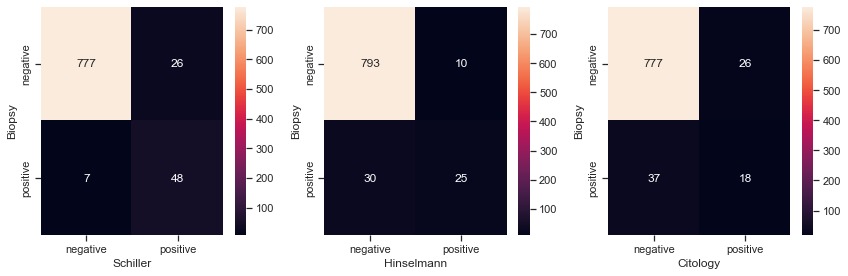

In [40]:
cols = list(df.columns.values)
cols.pop(cols.index('Biopsy'))
df = df[cols+['Biopsy']]
print(df.columns.values)
print("\n\nKoeficijenti korelacije izmedju prediktora i ciljne promenljive:")
print()
corr_coef = df.corr().iloc[:,-1].map(lambda x : x).abs().sort_values(ascending = False)
print(corr_coef)
fig,axs=plt.subplots(1,3,figsize=(12,4))
sns.heatmap(confusion_matrix(df['Biopsy'],df['Schiller']),annot=True, fmt="d",ax=axs[0])
axs[0].set_yticklabels(['negative', 'positive'])
axs[0].set_ylabel('Biopsy')
axs[0].set_xticklabels(['negative', 'positive'])
axs[0].set_xlabel('Schiller')
sns.heatmap(confusion_matrix(df['Biopsy'],df['Hinselmann']),annot=True, fmt="d",ax=axs[1])
axs[1].set_yticklabels(['negative', 'positive'])
axs[1].set_ylabel('Biopsy')
axs[1].set_xticklabels(['negative', 'positive'])
axs[1].set_xlabel('Hinselmann')
sns.heatmap(confusion_matrix(df['Biopsy'],df['Citology']),annot=True, fmt="d",ax=axs[2])
axs[2].set_yticklabels(['negative', 'positive'])
axs[2].set_ylabel('Biopsy')
axs[2].set_xticklabels(['negative', 'positive'])
axs[2].set_xlabel('Citology')
plt.tight_layout()

## Pretprocesiranje

Podaci su dalje odvojeni na deo koji se koristi za obučavanje i određivanje hiperparametara, i na deo koji se na kraju koristi za procenu kvaliteta modela. U skupovima je zadržan procentualni odnos zastupljenosti ciljnih klasa.

In [41]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train_raw, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Nedostajuće vrednosti biće popunjene srednjom vrednošću datog prediktora svih primera.

In [42]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed = imputer.fit_transform(X_train_raw)
X_train_imputed = pd.DataFrame(imputed, columns=X_train_raw.columns)

Vredosti prediktora se standardizuju.

In [43]:
scaler = StandardScaler().fit(X_train_imputed)
X_train_scaled = pd.DataFrame(data=scaler.transform(X_train_imputed), columns=X_train_imputed.columns)

Dalje, u cilju prevazilaženja velikog problema koji predstavlja nebalansiranost klasa, koristi se modul za nebalansirano učenje i funkcija za sintetičko generisanje primera. Formirani su dodatni primeri sa pozitivnim rezultatom biopsije. Sintetičko generisanje primera može da poremeti znanje modela o prirodnoj većoj zastupljenosti određene klase, međutim, ako model prevagne i smatra da je pojava raka češća nego što jeste u intresu je rane dijagnoze, i ta greška prihvatljivija je u sferi medicine. Drugo potencijalno rešenje nebalansiranosti je izostavljanje primera negativne dijagnoze, međutim zbog jako malog broja primera nad datim dataset-om takvo rešenje nije razmatrano.

In [45]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train_scaled, y_train)

Vrši se nasumično permutovanje primera. Podaci su spremni za obučavanje modela.

In [12]:
idx = np.random.permutation(X_train_smote.index)
X_train_smote.reindex(idx)
y_train_smote.reindex(idx)
X_train_final=X_train_smote
y_train_final=y_train_smote

## Formiranje modela

### KNN klasifikator

Sproveden je proces krosvalidacije sa metrikama recall i f1, za određivanje optimanog broja suseda iz opsega [3,29). Informativnija metrika u ovom slučaju je bila f1 i pronalaženjem argumenta njenog maksimuma za broj suseda je usvojeno 3.

In [13]:
f1_val = []
f1_train = []
rc_val = []
rc_train = []

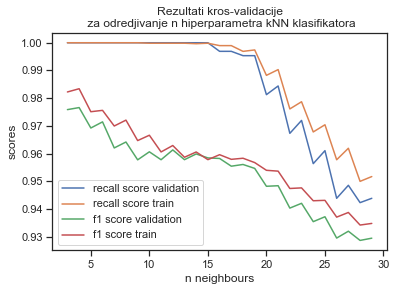

In [14]:
for nn in range(3, 30):
    neigh = KNeighborsClassifier(n_neighbors=nn)
    scores = cross_validate(neigh, X_train_final, y_train_final, cv=10, scoring=('recall', 'f1'),
                                return_train_score=True)
    rc_val.append(np.array(scores['test_recall']).mean())
    rc_train.append(np.array(scores['train_recall']).mean())
    f1_val.append(np.array(scores['test_f1']).mean())
    f1_train.append(np.array(scores['train_f1']).mean())

fig11, ax11 = plt.subplots()
ax11.plot(np.arange(3, 30), rc_val, label='recall score validation')
ax11.plot(np.arange(3, 30), rc_train, label='recall score train')
ax11.plot(np.arange(3, 30), f1_val, label='f1 score validation')
ax11.plot(np.arange(3, 30), f1_train, label='f1 score train')
ax11.set_title('Rezultati kros-validacije\n za odredjivanje n hiperparametra kNN klasifikatora')
ax11.set_xlabel('n neighbours')
ax11.set_ylabel('scores')
plt.legend()

In [17]:
k=3+np.argmax(f1_val)
print("Optimalan broj suseda je: %d" % k)

Optimalan broj suseda je: 4


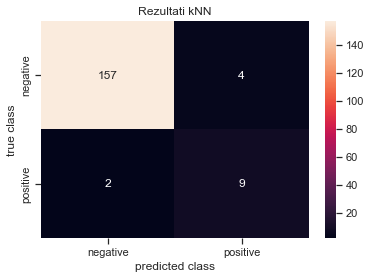

In [18]:
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_final, y_train_final)
y_pred = neigh.predict(pd.DataFrame(data=scaler.transform(imputer.transform(X_test)), columns=X_train_smote.columns))
M = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(M,annot=True, fmt="d")
ax.set_yticklabels(['negative', 'positive'])
ax.set_ylabel('true class')
ax.set_xticklabels(['negative', 'positive'])
ax.set_xlabel('predicted class')
ax.set_title('Rezultati kNN')
plt.show()

In [19]:
score_data = {}
score_df = pd.DataFrame(score_data, index =['kNN',
                                'SVM',
                                'Random Forest',
                                'Naive Bayes',
                                'Logistic Regression'])

In [20]:
score_df.loc['kNN','f1']=f1_score(y_test, y_pred)
score_df.loc['kNN','acc']=accuracy_score(y_test, y_pred)
score_df.loc['kNN','recall']=recall_score(y_test, y_pred)

In [21]:
print(score_df.loc['kNN'])

f1        0.750000
acc       0.965116
recall    0.818182
Name: kNN, dtype: float64


### SVM klasifikacija

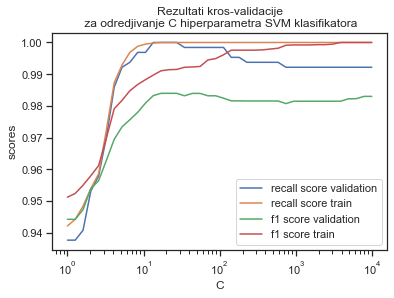

In [22]:
f1_val.clear()
f1_train.clear()
rc_val.clear()
rc_train.clear()
C = np.logspace(0, 4, 40)
for c in C:
    clf = SVC(C=c)
    scores = cross_validate(clf, X_train_final, y_train_final, cv=10, scoring=('recall', 'f1'),
                                    return_train_score=True)
    rc_val.append(np.array(scores['test_recall']).mean())
    rc_train.append(np.array(scores['train_recall']).mean())
    f1_val.append(np.array(scores['test_f1']).mean())
    f1_train.append(np.array(scores['train_f1']).mean())

fig12, ax12 = plt.subplots()
ax12.plot(C, rc_val, label='recall score validation')
ax12.plot(C, rc_train, label='recall score train')
ax12.plot(C, f1_val, label='f1 score validation')
ax12.plot(C, f1_train, label='f1 score train')
ax12.set_title('Rezultati kros-validacije\n za odredjivanje C hiperparametra SVM klasifikatora')
ax12.set_xlabel('C')
ax12.set_ylabel('scores')
ax12.set_xscale('log')
plt.legend()

In [23]:
c=C[np.argmax(rc_val)]
print(c)

13.433993325989


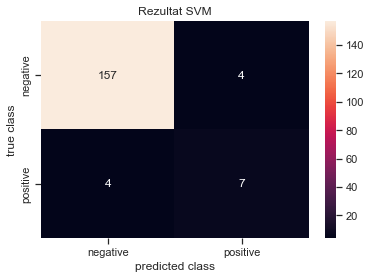

In [24]:
clf = SVC(C=c)
clf.fit(X_train_final, y_train_final)
y_pred = clf.predict(
        pd.DataFrame(data=scaler.transform(imputer.transform(X_test)), columns=X_train_smote.columns))
M = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(M,annot=True, fmt="d")
ax.set_yticklabels(['negative', 'positive'])
ax.set_ylabel('true class')
ax.set_xticklabels(['negative', 'positive'])
ax.set_xlabel('predicted class')
ax.set_title('Rezultat SVM')
plt.show()

In [25]:
score_df.loc['SVM','f1']=f1_score(y_test, y_pred)
score_df.loc['SVM','acc']=accuracy_score(y_test, y_pred)
score_df.loc['SVM','recall']=recall_score(y_test, y_pred)
print(score_df.loc['SVM'])

f1        0.636364
acc       0.953488
recall    0.636364
Name: SVM, dtype: float64


### Random Forest

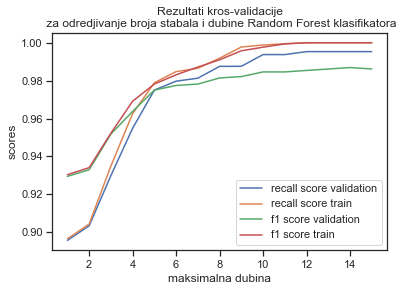

In [26]:
f1_val.clear()
f1_train.clear()
rc_val.clear()
rc_train.clear()
    
d_f1_val = []
d_f1_train = []
d_rc_val = []
d_rc_train = []
    
N_max = 100
N = np.linspace(1, N_max, int(N_max / 10))
D = np.linspace(1, 15, 15)
for d in D:
    d_f1_val.clear()
    d_f1_train.clear()
    d_rc_val.clear()
    d_rc_train.clear()
    for n in N:
        rfc = RandomForestClassifier(n_estimators=int(n), max_depth=int(d))
        cv_results = cross_validate(rfc, X_train_final, y_train_final, cv=10, scoring=('recall', 'f1'), return_train_score=True)
        d_rc_val.append(np.array(cv_results['test_recall']).mean())
        d_rc_train.append(np.array(cv_results['train_recall']).mean())
        d_f1_val.append(np.array(cv_results['test_f1']).mean())
        d_f1_train.append(np.array(cv_results['train_f1']).mean())
    f1_val.append(max(d_f1_val))
    f1_train.append(max(d_f1_train))
    rc_val.append(max(d_rc_val))
    rc_train.append(max(d_rc_train))

fig13, ax13 = plt.subplots()
ax13.plot(D, rc_val, label='recall score validation')
ax13.plot(D, rc_train, label='recall score train')
ax13.plot(D, f1_val, label='f1 score validation')
ax13.plot(D, f1_train, label='f1 score train')
ax13.set_title('Rezultati kros-validacije\n za odredjivanje broja stabala i dubine Random Forest klasifikatora')
ax13.set_xlabel('maksimalna dubina')
ax13.set_ylabel('scores')
plt.legend()

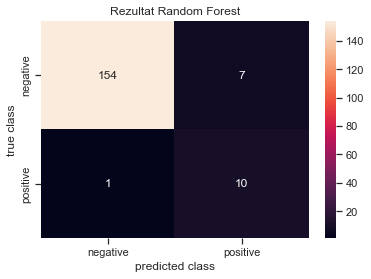

In [27]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=10)
rfc.fit(X_train_final,y_train_final)
y_pred = rfc.predict(pd.DataFrame(data=scaler.transform(imputer.transform(X_test)), columns=X_train_smote.columns))
M = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(M,annot=True, fmt="d")
ax.set_yticklabels(['negative', 'positive'])
ax.set_ylabel('true class')
ax.set_xticklabels(['negative', 'positive'])
ax.set_xlabel('predicted class')
ax.set_title('Rezultat Random Forest')
plt.show()

In [28]:
score_df.loc['Random Forest','f1']=f1_score(y_test, y_pred)
score_df.loc['Random Forest','acc']=accuracy_score(y_test, y_pred)
score_df.loc['Random Forest','recall']=recall_score(y_test, y_pred)
print(score_df.loc['Random Forest'])

f1        0.714286
acc       0.953488
recall    0.909091
Name: Random Forest, dtype: float64


### Bernoulli Naive Bayes

Ovaj tip klasifikatora pokazao se kao veoma efikasan, iako vrši binarizaciju svih dostupnih prediktora. Međutim, on uzima u obzir da su aprione verovatnoće pojave klasa različite iako su primeri kasnije sintetički izbalansirani.

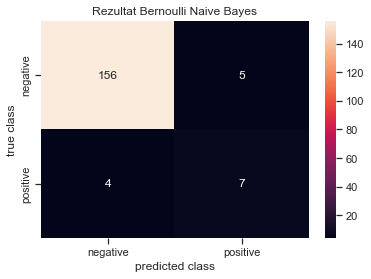

In [29]:
bnb = BernoulliNB(class_prior=np.array([0.94,0.06]))
bnb.fit(X_train_final, y_train_final)
y_pred = bnb.predict(pd.DataFrame(data=scaler.transform(imputer.transform(X_test)), columns=X_train_smote.columns))
M = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(M,annot=True, fmt="d")
ax.set_yticklabels(['negative', 'positive'])
ax.set_ylabel('true class')
ax.set_xticklabels(['negative', 'positive'])
ax.set_xlabel('predicted class')
ax.set_title('Rezultat Bernoulli Naive Bayes')
plt.show()

In [30]:
score_df.loc['Naive Bayes','f1']=f1_score(y_test, y_pred)
score_df.loc['Naive Bayes','acc']=accuracy_score(y_test, y_pred)
score_df.loc['Naive Bayes','recall']=recall_score(y_test, y_pred)
print(score_df.loc['Naive Bayes'])

f1        0.608696
acc       0.947674
recall    0.636364
Name: Naive Bayes, dtype: float64


### Logistička regresija

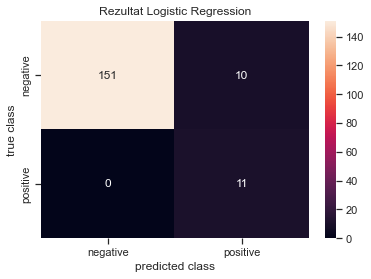

In [31]:
clf = LogisticRegression(random_state=0).fit(X_train_final, y_train_final)
y_pred = clf.predict(pd.DataFrame(data=scaler.transform(imputer.transform(X_test)), columns=X_train_smote.columns))
M = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(M,annot=True, fmt="d")
ax.set_yticklabels(['negative', 'positive'])
ax.set_ylabel('true class')
ax.set_xticklabels(['negative', 'positive'])
ax.set_xlabel('predicted class')
ax.set_title('Rezultat Logistic Regression')
plt.show()

In [32]:
score_df.loc['Logistic Regression','f1']=f1_score(y_test, y_pred)
score_df.loc['Logistic Regression','acc']=accuracy_score(y_test, y_pred)
score_df.loc['Logistic Regression','recall']=recall_score(y_test, y_pred)
print(score_df.loc['Logistic Regression'])

f1        0.68750
acc       0.94186
recall    1.00000
Name: Logistic Regression, dtype: float64


## Pregled tačnosti

In [33]:
print("Krajnje postignute tačnosti:\n")
print(score_df)

Krajnje postignute tačnosti:

                           f1       acc    recall
kNN                  0.750000  0.965116  0.818182
SVM                  0.636364  0.953488  0.636364
Random Forest        0.714286  0.953488  0.909091
Naive Bayes          0.608696  0.947674  0.636364
Logistic Regression  0.687500  0.941860  1.000000


## Zaključak

Izvršeno je formiranje nekoliko modela čiji je cilj predikcija rezultata biopsije raka grlića materice na osnovu faktora rizika i rezultata kliničkih testova. Modeli sa lošijim performansama su SVM i Bernoulli Naive Bayes. Po pitanju detekcije pozitivnih najbolja je logistička regresija. kNN ima najbolju vrednost f1 skora, međutim Random Forest ima nešto veću recall vrednost koja je jako bitna kod dijagnostike. Svi razmatrani modeli uspešno su se izborili sa različitim tipovim prediktora. Za dalji rad razmatra se mogućnost formiranja klasifikatora samo na osnovu faktora rizika. Pokušaj formiranja ovakvog načina predikcije nije davao zadovoljavajuće rezultate korišćenjem samo dostupnog dataset-a. Potrebno je nastaviti potragu za zaista diskriminišućim svojstvima, kao i pronaći dodatne primere pozitivnih nalaza u cilju rada sa balansiranim klasama.